<a href="https://colab.research.google.com/github/rickyyhs/data-analysis-python/blob/main/Kaggle_Amazon_Top_50_Best_Seller_Books_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amazon Top 50 Bestselling Books Analysis**

**Top 50 buku terlaris Amazon dari 2009 hingga 2019. Berisi 550 buku, data telah dikategorikan menjadi fiksi dan non-fiksi.**


**Dataset: https://www.kaggle.com/sootersaalu/amazon-top-50-bestselling-books-2009-2019**

In [1]:
# installing fuzzywuzzy library
!pip install fuzzywuzzy 

In [2]:
# import library yang dibutuhkan
import fuzzywuzzy
from fuzzywuzzy import process
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import zipfile, os
print('done')

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


done


# **1. Load & Preprocessing Data**

In [3]:
# ekstrak dataset
path = '/content/archive(2).zip'
zip_file = zipfile.ZipFile(path, 'r')
zip_file.extractall('/content')
zip_file.close()

df_path = '/content/bestsellers with categories.csv'
df = pd.read_csv(df_path, index_col='Year').sort_index()

In [4]:
# menampilkan 5 data teratas
df.head()

,Name,Author,User Rating,Reviews,Price,Genre
Year,,,,,,
2009,"I, Alex Cross",James Patterson,4.6,1320,7,Fiction
2009,Glenn Beck's Common Sense: The Case Against an...,Glenn Beck,4.6,1365,11,Non Fiction
2009,The Last Lecture,Randy Pausch,4.7,4028,9,Non Fiction
2009,New Moon (The Twilight Saga),Stephenie Meyer,4.6,5680,10,Fiction
2009,Diary of a Wimpy Kid: The Last Straw (Book 3),Jeff Kinney,4.8,3837,15,Fiction


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 2009 to 2019
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Genre        550 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 30.1+ KB


In [6]:
# menampilkan jumlah nilai unique pada kolom non numerik
columns = list(df.select_dtypes(exclude=('int64','float64')).columns)
for col in columns:
  print('jumlah unique pada kolom {}: {}'.format(col, df[col].nunique()))

jumlah unique pada kolom Name: 351
jumlah unique pada kolom Author: 248
jumlah unique pada kolom Genre: 2


In [7]:
# menampilkan informasi missing value
df.isna().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Genre          0
dtype: int64

In [8]:
# menampilkan rows pada kolom Author
authors = df.Author.sort_values().unique()
authors

array(['Abraham Verghese', 'Adam Gasiewski', 'Adam Mansbach', 'Adir Levy',
       'Admiral William H. McRaven', 'Adult Coloring Book Designs',
       'Alan Moore', 'Alex Michaelides', 'Alice Schertle', 'Allie Brosh',
       'American Psychiatric Association',
       'American Psychological Association', 'Amor Towles', 'Amy Ramos',
       'Amy Shields', 'Andy Weir', 'Angie Grace', 'Angie Thomas',
       'Ann Voskamp', 'Ann Whitford Paul', 'Anthony Bourdain',
       'Anthony Doerr', 'Atul Gawande', 'Audrey Niffenegger',
       'B. J. Novak', 'Bessel van der Kolk M.D.', 'Bill Martin Jr.',
       "Bill O'Reilly", 'Bill Simmons', 'Blue Star Coloring',
       'Bob Woodward', 'Brandon Stanton', 'Brené Brown',
       'Brian Kilmeade', 'Bruce Springsteen', 'Carol S. Dweck',
       'Celeste Ng', 'Charlaine Harris', 'Charles Duhigg',
       'Charles Krauthammer', 'Cheryl Strayed', 'Chip Gaines',
       'Chip Heath', 'Chris Cleave', 'Chris Kyle', 'Chrissy Teigen',
       'Christina Baker Kline', 

Pada kolom Author, Penulis dengan nama J.K. Rowling dan J. K. Rowling merujuk pada orang yang sama, namun kedua nama tersebut memiliki format penulisan yang berbeda (penggunaan tanda spasi sebelum abjad K), sehingga nama tersebut dianggap sebagai 2 orang yang berbeda. Hal yang sama juga terjadi pada penulis dengan nama George R.R. Martin dan George R. R. Martin.


Untuk menyamakan format penulisan, selanjutnya akan dibuat sebuah fungsi dengan nama matches_in_columns menggunakan library fuzzywuzzy untuk menampilkan 2 atau lebih nilai yang memiliki kemiripan.

In [9]:
def matches_in_columns(df, column, string):
  unique_string = df[column].unique()

  matches_string = fuzzywuzzy.process.extract(string, unique_string, limit=4)
  print(matches_string)

matches_in_columns(df, 'Author', 'J. K. Rowling')
matches_in_columns(df, 'Author', 'George R.R Martin')

[('J. K. Rowling', 100), ('J.K. Rowling', 96), ('Jim Collins', 50), ('J. D. Vance', 50)]
[('George R.R. Martin', 97), ('George R. R. Martin', 95), ('Mark Twain', 68), ('George W. Bush', 60)]


Selanjutnya menggunakan fungsi replace untuk menyamakan format penulisan yang berbeda.


In [10]:
df['Author'].replace('J.K. Rowling', 'J. K. Rowling', inplace=True)
df['Author'].replace('George R.R. Martin', 'George R. R. Martin', inplace=True)

In [11]:
# menampilkan duplikasi pada kolom Name
print(f'Before duplicated: {df.Name.duplicated().sum()}')

# drop rows yang memiliki duplikasi data, dengan mempertahankan nilai terakhir yang dianggap sebagai data terbaru
df = df.drop_duplicates(subset='Name', keep='last')
print(f'After duplicated: {df.Name.duplicated().sum()}')

Before duplicated: 199
After duplicated: 0


# **2. Exploratory Data Analysis**

In [12]:
# menampilkan proporsi unique values pada kolom Genre
genre = df['Genre'].value_counts().to_frame()
genre = genre.sort_index()
genre.columns = ['counts']
genre

,counts
Fiction,160
Non Fiction,191


No handles with labels found to put in legend.


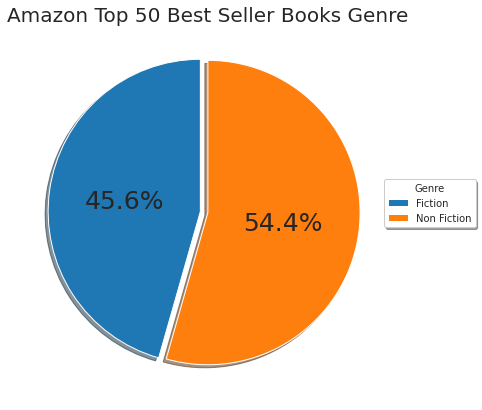

In [66]:
#plot proporsi genre pada dataset Amazon Top 50 Bestselling Books
genre.plot(kind='pie',
           figsize=(10,7),
           autopct='%1.1f%%',
           pctdistance=0.5,
           textprops={'fontsize': 25},
           startangle=90,
           shadow=True,
           labels=None,
           subplots=True,
           explode=[0.05, 0])

plt.title('Amazon Top 50 Best Seller Books Genre', pad=1, size=20)
plt.ylabel(None)
plt.legend(bbox_to_anchor=(0.95, 0.60),labels=genre.index, shadow=True, ncol=1, title='Genre')
plt.show()

Berdasarkan grafik diatas, terdapat 160 buku dengan genre "Fiction" atau sebesar 45.6%, dan 191 buku dengan genre "Non Fiction" atau sebesar 54.4%


In [16]:
most_review = df[df['User Rating']==4.9].sort_values('Reviews', ascending=False)
most_review.head()

,Name,Author,User Rating,Reviews,Price,Genre
Year,,,,,,
2019,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,Fiction
2016,Harry Potter and the Chamber of Secrets: The I...,J. K. Rowling,4.9,19622,30,Fiction
2016,Jesus Calling: Enjoying Peace in His Presence ...,Sarah Young,4.9,19576,8,Non Fiction
2019,The Very Hungry Caterpillar,Eric Carle,4.9,19546,5,Fiction
2019,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,Fiction


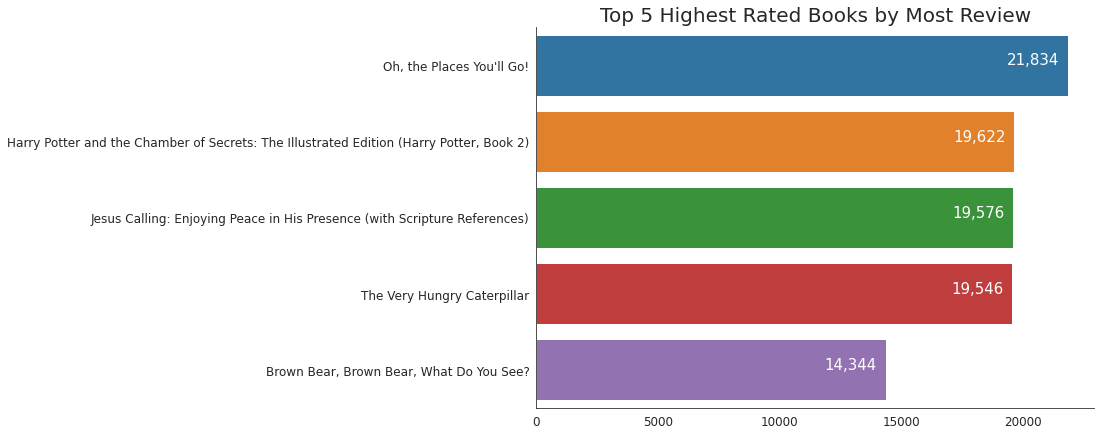

In [41]:
sns.set_style('white')
plt.figure(figsize=(10,7))

sns.barplot(x='Reviews', y='Name', data=most_review.head())
plt.title('Top 5 Highest Rated Books by Most Review', size=20)
sns.despine(top=True, right=True)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(False)

for i, value in enumerate(most_review['Reviews'].head()):
  label = format(int(value), ',')
  plt.annotate(label, xy=(value - 2500, i - 0.01), color='white', size=15)

Grafik diatas menampilkan informasi mengenai buku dengan rating tertinggi dan jumlah review terbanyak.

Buku dengan Judul "Oh, the Places You'll Go!" karangan Dr. Seuss mendapatkan rating tertinggi dan jumlah review terbanyak, diikut dengan novel series Harry Potter karangan J. K. Rowling, dan seterusnya. Dapat disimpulkan bahwa kelima buku ini merupakan buku terlaris pada situs penjualan Amazon sepanjang tahun 2009 sampai dengan 2019.

In [14]:
# menampilkan nama author berdasarkan rating dan jumlah review tertinggi 
best_ratings = df[df['User Rating']==4.9].groupby('Author')['Reviews'].sum().sort_values(ascending=False).reset_index()
best_ratings.head()

,Author,Reviews
0,Dav Pilkey,44261
1,J. K. Rowling,40578
2,Dr. Seuss,21834
3,Sarah Young,19576
4,Eric Carle,19546


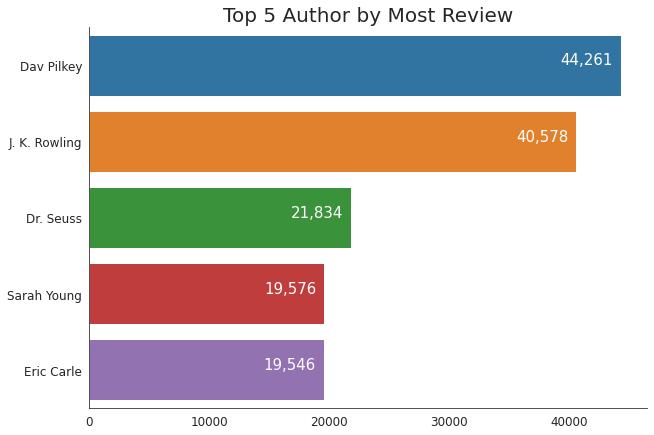

In [15]:
# plot nama author berdasarkan rating dan jumlah review tertinggi 
plt.figure(figsize=(10,7))

sns.set_style('white')
sns.barplot(x='Reviews', y='Author', data=best_ratings.head())
sns.despine(top=True)
plt.title('Top 5 Author by Most Review', size=20)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(False)

for i, value in enumerate(best_ratings['Reviews'].head()):
  label = format(int(value), ',')
  plt.annotate(label, xy=(value - 5000, i - 0.01), color='white', size=15)

Grafik diatas menunjukkan bahwa Dav Pilkey memiliki review terbanyak dengan 44261 review, disusul oleh J. K. Rowling dengan 40578 review, Dr. Seuss dengan 21834 review, Sarah Young dengan 19576 review, dan Eric Carle dengan 19546 review.

Total review diperoleh berdasarkan jumlah review pada masing-masing buku pada author yang sama, dimana buku yang diambil hanya pada buku dengan rating 4.9 (rating tertinggi)

In [18]:
most_expensive_book = df.sort_values(by='Price', ascending=False).head()
most_expensive_book

,Name,Author,User Rating,Reviews,Price,Genre
Year,,,,,,
2014,Diagnostic and Statistical Manual of Mental Di...,American Psychiatric Association,4.5,6679,105,Non Fiction
2009,The Twilight Saga Collection,Stephenie Meyer,4.7,3801,82,Fiction
2016,Hamilton: The Revolution,Lin-Manuel Miranda,4.9,5867,54,Non Fiction
2009,The Book of Basketball: The NBA According to T...,Bill Simmons,4.7,858,53,Non Fiction
2016,Harry Potter Paperback Box Set (Books 1-7),J. K. Rowling,4.8,13471,52,Fiction


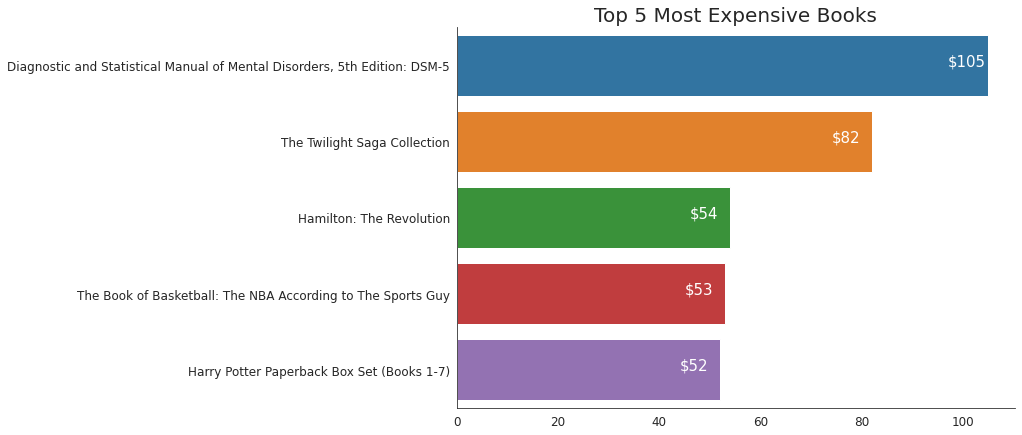

In [28]:
plt.figure(figsize=(10,7))
sns.barplot(x=most_expensive_book['Price'], y=most_expensive_book.Name)
plt.title('Top 5 Most Expensive Books', size=20)
sns.despine(top=True, right=True)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(False)

for i, value in enumerate(most_expensive_book['Price'].head()):
  label = str('$') + format(int(value), ',') 
  plt.annotate(label, xy=(value - 8, i - 0.001), color='white', size=15)

Grafik diatas menampilkan informasi mengenai buku dengan harga paling tinggi pada Amazon. Buku dengan judul "Diagnostic and Statistical Manual of Mental Disorders, 5th Edition: DSM-5" merupakan buku dengan harga tertinggi sebesar $105

# **3. Apakah terdapat korelasi antara Reviews, User Rating, dan Price?**

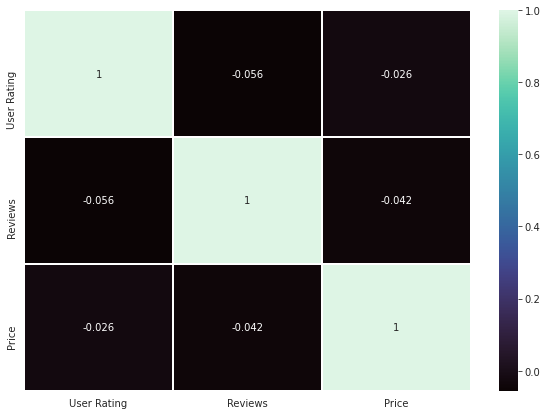

In [23]:
# plot korelasi antar kolom 'User Rating', 'Reviews', 'Price'
plt.figure(figsize=(10,7))
sns.heatmap(df[['User Rating', 'Reviews', 'Price']].corr(), annot=True, linewidths=.5, cmap='mako')
plt.show()

Grafik diatas menampilkan informasi mengenai hubungan linear antar kolom numerik (Price, User Rating, Reviews)

Tidak terdapat korelasi yang kuat antara masing-masing kolom, baik pada kolom Price dan User Rating, Price dan Reviews, maupun User Rating dan Reviews

Langkah selanjutnya menggunakan fungsi lmplot dari library seaborn untuk memeriksa hubungan linear antar kolom numerik berdasarkan genre yaitu "Fiction" dan "Non Fiction"

<Figure size 720x504 with 0 Axes>

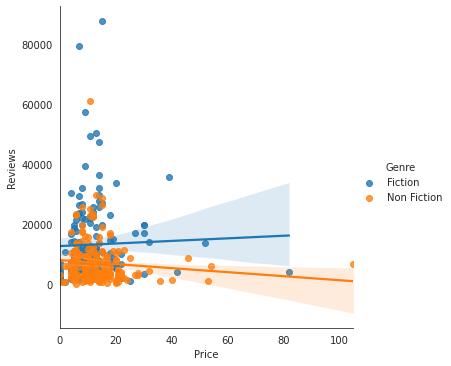

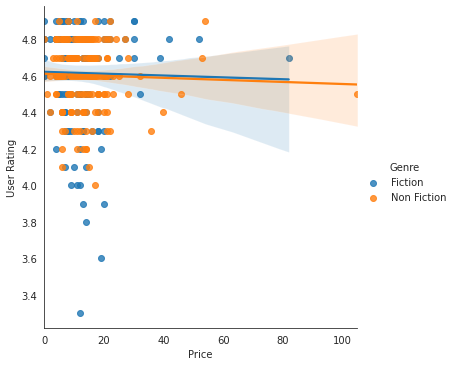

In [24]:
plt.figure(figsize=(10,7))
sns.lmplot(x='Price', y='Reviews', hue='Genre', data=df)

sns.lmplot(x='Price', y='User Rating', hue='Genre', data=df)
plt.show()

Pada grafik pertama, dapat dilihat bahwa tidak terdapat korelasi yang kuat antara kolom Price dan Reviews, baik pada genre Fiction maupun Non Fiction. Begitu juga dengan grafik kedua.

Dapat disimpulkan bahwa Price tidak menentukan banyaknya review yang diterima oleh sebuah buku, hal yang sama juga berlaku pada grafik kedua, dimana Price menentukan besarnya rating dari sebuah buku.

<Figure size 720x504 with 0 Axes>

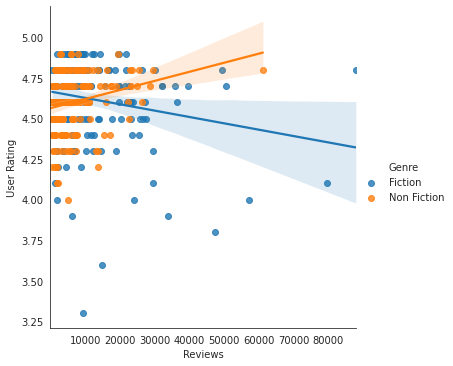

In [67]:
plt.figure(figsize=(10,7))
sns.lmplot(x='Reviews', y='User Rating', hue='Genre', data=df)
plt.show()

Pada genre Fiction, dapat dilihat bahwa garis linear sedikit mengarah kebawah yang berarti terdapat sedikit korelasi negatif untuk Reviews dan User Rating, artinya meningkatnya jumlah review berbanding terbalik dengan rating pada sebuah buku.

Sementara pada genre Non Fiction, korelasi yang ditunjukkan berbanding terbalik dengan korelasi yang ditunjukkan pada genre Fiction, dimana Reviews dan User Rating memiliki garis linear yang cenderung mengarah keatas, artinya meningkatnya jumlah review berbanding lurus dengan rating pada sebuah buku.

Dari kedua genre ini, dapat dikatakan bahwa review yang didapat menentukan seberapa besar rating yang diterima oleh sebuah buku, namun informasi ini tidak dapat sepenuhnya dijadikan acuan dikarenakan korelasi yang dimiliki bukanlah korelasi yang kuat.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


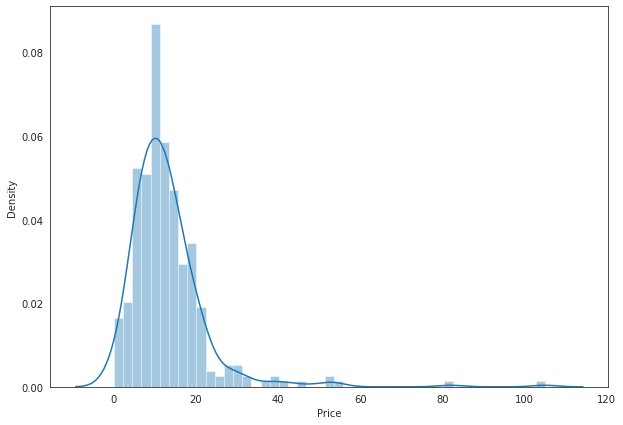

count    351.000000
mean      12.985755
std       10.016120
min        0.000000
25%        8.000000
50%       11.000000
75%       16.000000
max      105.000000
Name: Price, dtype: float64


In [26]:
plt.figure(figsize=(10,7))
sns.distplot(a=df['Price'])
plt.show()

print(df['Price'].describe())

Plot diatas merupakan informasi mengenai persebaran harga pada data "Top 50 Best Selling Books Amazon", dimana insight yang didapat adalah terdapat buku dengan harga terendah sebesar 0 USD dan harga tertinggi sebesar  105 USD

# **4. Kesimpulan**

1. Top 50 Best Selling Books pada Amazon terdiri dari 2 genre yaitu Fiction dan Non Fiction, dimana terdapat 45.6% buku dengan genre Fiction dan 54.4% buku dengan genre Non Fiction. 
2. "Oh, The Places You'll Go!" merupakan buku terlaris  dengan jumlah review dan rating tertinggi pada Amazon Top 50 Best Selling Books.
3. Dav Pilkey, J. K. Rowling, Dr. Seuss, Sarah Young, Eric Carle merupakan author terbaik dengan jumlah review dan rating tertinggi pada masing-masing buku yang dirilis.
4. "Diagnostic and Statistical Manual of Mental Disorders, 5th Edition: DSM-5" merupakan buku dengan harga tertinggi sebesar 105 USD, selain itu juga terdapat beberapa buku dengan harga 0 USD